# Plotting Functions for BH Population

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python.snapshot as snapshot
import illustris_python.groupcat as gc
from matplotlib.colors import LogNorm
import pandas as pd
import matplotlib.font_manager
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from scipy.ndimage import gaussian_filter1d
import matplotlib.ticker as ticker
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import utils as util
from matplotlib.gridspec import GridSpec

# Plotting settings
fpaths = matplotlib.font_manager.findSystemFonts()
plt.rc('font', family='Nimbus Roman', size = 9)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

In [2]:
colour_map = sns.color_palette("rocket")
colour_map_2 = sns.color_palette("husl", 8)

In [3]:
base_path = '/cosma7/data/dp012/dc-bigw2/FABLE-NewICs/FABLE-newICs-100'
LITTLE_H = 0.679

## BH Mass Relation

In [ ]:
# Load the data generated by poopulation.py script

bh_masses1 = np.loadtxt('../data/bh_masses_85.txt')
host_masses1 = np.loadtxt('../data/host_masses_total_85.txt')
bh_masses2 = np.loadtxt('../data/bh_masses_68.txt')
host_masses2 = np.loadtxt('../data/host_masses_total_68.txt')
bh_masses3 = np.loadtxt('../data/bh_masses_60.txt')
host_masses3 = np.loadtxt('../data/host_masses_total_60.txt')
bh_masses4 = np.loadtxt('../data/bh_masses_54.txt')
host_masses4 = np.loadtxt('../data/host_masses_total_54.txt')
bh_masses0 = np.loadtxt('../data/bh_masses_135.txt')
host_masses0 = np.loadtxt('../data/host_masses_135.txt')

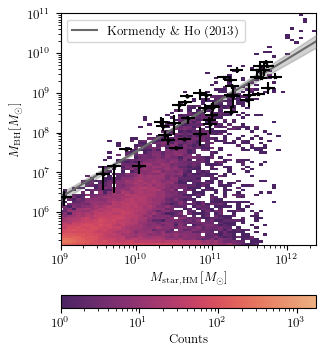

In [ ]:
# Define the constants and exponent with their uncertainties for the Kormendy and Ho fit
a = 0.49
a_err_high = 0.06
a_err_low = 0.05
b = 1.16
b_err = 0.08

# Function to calculate black hole mass from fit
def black_hole_mass(M_bulge, a, b):
    M_bh = 10**9 * a * (M_bulge / 10**11)**b
    return M_bh

# Generate a range of bulge masses (from 10^9 to 10^12 solar masses)
M_bulge_range = np.logspace(9, 13, 100)

# Calculate the corresponding black hole masses for the central values
M_bh_range = black_hole_mass(M_bulge_range, a, b)

# Calculate the upper and lower bounds
M_bh_range_upper = black_hole_mass(M_bulge_range, a + a_err_high, b + b_err)
M_bh_range_lower = black_hole_mass(M_bulge_range, a - a_err_low, b - b_err)

# Define the parameters of the relation
slope = 1.24
intercept = 8.80

# Define the uncertainties in the parameters
slope_uncertainty = 0.08
intercept_uncertainty = 0.09

# Calculate the upper and lower bounds for the relation
upper_bound = (slope + slope_uncertainty) * np.log10(M_bulge_range / 1e11) + (intercept + intercept_uncertainty)
lower_bound = (slope - slope_uncertainty) * np.log10(M_bulge_range / 1e11) + (intercept - intercept_uncertainty)

# Calculate the main relation
main_relation = slope * np.log10(M_bulge_range / 1e11) + intercept

# Bin the FABLE data
mask = np.where(host_masses0 > 0)

bh_masses = bh_masses0[mask]
host_masses = host_masses0[mask]

min_host_mass = np.min(host_masses)
max_host_mass = np.max(host_masses)

min_bh_mass = np.min(bh_masses)
max_bh_mass = np.max(bh_masses)

# Generate log-spaced bins
host_mass_bins = np.logspace(np.log10(min_host_mass), np.log10(max_host_mass), 100)
bh_mass_bins = np.logspace(np.log10(min_bh_mass), np.log10(max_bh_mass), 100)

colour_map = sns.color_palette("flare_r", as_cmap=True)

# plot
plt.figure(figsize=(10/3, 3.7))
plt.hist2d(host_masses, bh_masses, bins=[host_mass_bins, bh_mass_bins], cmap=colour_map, norm=LogNorm())

# # Add a colorbar
plt.colorbar(label='Counts', orientation= 'horizontal')

plt.plot(M_bulge_range, M_bh_range, color='dimgrey', label=r'Kormendy \& Ho (2013)', zorder = 5)
plt.fill_between(M_bulge_range, M_bh_range_lower, M_bh_range_upper, color='dimgrey', alpha=0.3, zorder = 4)

# plot data points used for Kormendy and Ho fit
ellipticals = pd.read_csv('../data/ellipticals.csv', sep=',', header=None)

# Extract the data from the DataFrame
log_mbulge = ellipticals[0].values
mbulge_uncertainty = ellipticals[1].values
mbh = ellipticals[2].values
mbh_lower = ellipticals[3].values
mbh_upper = ellipticals[4].values
exponent = ellipticals[5].values

# Convert log_mbulge to linear scale
mbulge = 10**log_mbulge

# Calculate the upper and lower error bars for mbulge
mbulge_lower_error = mbulge - 10**(log_mbulge - mbulge_uncertainty)
mbulge_upper_error = 10**(log_mbulge + mbulge_uncertainty) - mbulge

# Calculate the upper and lower error bars for mbh
mbh = mbh * exponent
mbh_lower_error = mbh - (mbh_lower * exponent)
mbh_upper_error = (mbh_upper * exponent) - mbh

bulges = pd.read_csv('../data/bulges.csv', sep=',', header=None)

# Extract the data from the DataFrame
log_mbulge_b = bulges[0].values
mbulge_uncertainty_b = bulges[1].values
mbh_b = bulges[2].values
mbh_lower_b = bulges[3].values
mbh_upper_b = bulges[4].values
exponent_b = bulges[5].values

# Convert log_mbulge to linear scale
mbulge_b = 10**log_mbulge_b

# Calculate the upper and lower error bars for mbulge
mbulge_lower_error_b = mbulge_b - 10**(log_mbulge_b - mbulge_uncertainty_b)
mbulge_upper_error_b = 10**(log_mbulge_b + mbulge_uncertainty_b) - mbulge_b

# Calculate the upper and lower error bars for mbh
mbh_b = mbh_b * exponent_b
mbh_lower_error_b = mbh_b - (mbh_lower_b * exponent_b)
mbh_upper_error_b = (mbh_upper_b * exponent_b) - mbh_b

# Set labels and scales
plt.xlabel(r'$M_{\mathrm{star,HM}} [M_{\odot}]$')
plt.ylabel(r'$M_{\mathrm{BH}} [M_{\odot}]$')
# plt.scatter(host_masses, bh_masses, color='red', label='Selected Points')
plt.errorbar(mbulge_b, mbh_b, xerr=[mbulge_lower_error_b, mbulge_upper_error_b], yerr=[mbh_lower_error_b, mbh_upper_error_b], fmt='o', color='dimgrey', zorder = 5, markersize=2)
plt.errorbar(mbulge, mbh, xerr=[mbulge_lower_error, mbulge_upper_error], yerr=[mbh_lower_error, mbh_upper_error], fmt='x', color='dimgrey', zorder = 5, markersize=2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left = 1e9)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('../figures/mass_relation_2d_histogram.png', dpi = 600)

<>:66: SyntaxWarning: invalid escape sequence '\&'
<>:66: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_1018992/474389551.py:66: SyntaxWarning: invalid escape sequence '\&'
  ax.plot(M_bulge_range, M_bh_range, color='black', label=f'Reines \& \n Volonteri (2015)', zorder=5)


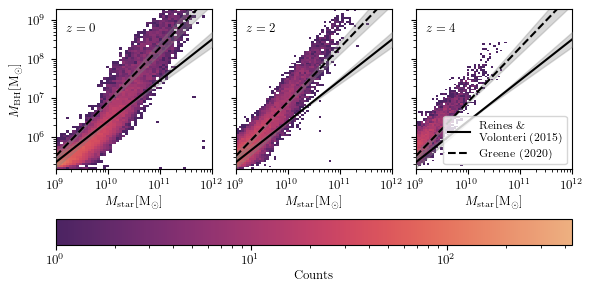

In [27]:
redshifts = [0, 2, 4]  # Updated redshifts
colour_map = sns.color_palette("flare_r", as_cmap=True)

a = 7.45
a_err = 0.08
b = 1.05
b_err = 0.11

a_g = 7.56
a_g_err = 0.09
b_g = 1.39
b_g_err = 0.13
eps = 0.79
eps_err = 0.05

# Function to calculate black hole mass
def black_hole_mass_rv(M_stellar, a, b): # using Eq. 4 in Reines & Volonteri
    M_bh = 10**(a+b*np.log10(M_stellar/1e11))
    return M_bh

def black_hole_mass_g(M_stellar, a, b, eps):
    log_m = a + b*np.log10(M_stellar/(3*1e10))
    return 10**log_m

# Generate a range of bulge masses (from 10^9 to 10^12 solar masses)
M_bulge_range = np.logspace(9, 12, 100)

# Calculate the corresponding black hole masses for the central values
M_bh_range = black_hole_mass_rv(M_bulge_range, a, b)
M_bh_range_g = black_hole_mass_g(M_bulge_range, a_g, b_g, eps)

# Calculate the upper and lower bounds
M_bh_range_upper = black_hole_mass_rv(M_bulge_range, a + a_err, b + b_err)
M_bh_range_lower = black_hole_mass_rv(M_bulge_range, a - a_err, b - b_err)

M_bh_range_upper_g = black_hole_mass_g(M_bulge_range, a_g+a_g_err, b_g+b_g_err, eps+eps_err)
M_bh_range_lower_g = black_hole_mass_g(M_bulge_range, a_g-a_g_err, b_g-b_g_err, eps-eps_err)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(20/3, 3.2), sharey=True, gridspec_kw={'wspace': 0.15})

# List of data sets
bh_masses_list = [bh_masses0, bh_masses2, bh_masses4]  # Updated data sets
host_masses_list = [host_masses0, host_masses2, host_masses4]  # Updated data sets

# Plot each data set
for i, (bh_masses, host_masses) in enumerate(zip(bh_masses_list, host_masses_list)):
    ax = axs[i]
    
    mask = np.where(host_masses > 0)
    bh_masses = bh_masses[mask]
    host_masses = host_masses[mask]
    mask2 = np.where(bh_masses > 0)
    bh_masses = bh_masses[mask2]
    host_masses = host_masses[mask2]

    min_host_mass = np.min(host_masses)
    max_host_mass = np.max(host_masses)
    min_bh_mass = np.min(bh_masses)
    max_bh_mass = np.max(bh_masses)

    host_mass_bins = np.logspace(np.log10(min_host_mass), np.log10(max_host_mass), 100)
    bh_mass_bins = np.logspace(np.log10(min_bh_mass), np.log10(max_bh_mass), 100)

    hist = ax.hist2d(host_masses, bh_masses, bins=[host_mass_bins, bh_mass_bins], cmap=colour_map, norm=LogNorm())
    ax.plot(M_bulge_range, M_bh_range, color='black', label=f'Reines \& \n Volonteri (2015)', zorder=5)
    ax.plot(M_bulge_range, M_bh_range_g, color='black', linestyle='--', label=r'Greene (2020)')
    ax.fill_between(M_bulge_range, M_bh_range_lower, M_bh_range_upper, color='gray', alpha=0.3, zorder=4)
    ax.fill_between(M_bulge_range, M_bh_range_lower_g, M_bh_range_upper_g, color='gray', alpha = 0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1e9, right=1e12)
    ax.set_xlabel(r'$M_{\mathrm{star}} [\mathrm{M}_{\odot}]$')
    # ax.set_ylabel(r'$M_{\mathrm{BH}} [M_{\odot}]$')

    if i==0:
        ax.set_ylabel(r'$M_{\mathrm{BH}} [\mathrm{M}_{\odot}]$')
    if i==2:
        ax.legend(loc='lower right', fontsize=8)

    ax.text(10**(9.2), 10**(8.7), f'$z = {redshifts[i]}$', fontsize=9, color='black')

# Add a common colorbar
cbar = fig.colorbar(hist[3], ax=axs, orientation='horizontal', pad=0.2)
cbar.set_label('Counts')

plt.savefig('../figures/final_results/mass_relation_3_plots.png', dpi=600, bbox_inches='tight')
plt.show()

## Black Hole Accretion Rate Density and SFRD

In [11]:
# Load the data and bin according to BH mass

bh_accretion_rate_density = np.array([])*u.Msun/u.Mpc**3/u.yr
sfrd = np.array([])*u.Msun/u.yr/u.Mpc**3
redshifts = np.array([])
bhard1 = np.array([])*u.Msun/u.yr/u.Mpc**3
bhard2 = np.array([])*u.Msun/u.yr/u.Mpc**3
bhard3 = np.array([])*u.Msun/u.yr/u.Mpc**3
bhard4 = np.array([])*u.Msun/u.yr/u.Mpc**3
bhard5 = np.array([])*u.Msun/u.yr/u.Mpc**3
for snap in range(1,136):
    print('Loading snapshot', snap)
    # Read information from header
    file_path_snap = base_path+f"/snapdir_{snap:03d}/snap_{snap:03d}.0.hdf5"
    with h5py.File(file_path_snap, 'r') as hf:
        header = dict(hf['Header'].attrs.items())
        h = header['HubbleParam']
        redshift = header['Redshift']
        redshifts = np.append(redshifts, redshift)            
        side_length = header['BoxSize']*u.kpc/h
        volume = (side_length**3).to(u.Mpc**3)

    bh_accretion_rates = snapshot.loadSubset(base_path, snap, partType=5, fields='BH_Mdot')
    subhalo_sfr = gc.loadSubhalos(base_path, snap, fields='SubhaloSFRinHalfRad')
    if isinstance(bh_accretion_rates, np.ndarray):
        bh_accretion_rates = bh_accretion_rates*10**10*u.Msun/h/(0.978*u.Gyr/h)
        total_bhar = np.sum(bh_accretion_rates)
    else:
        bh_accretion_rates = np.array([])
        total_bhar = 0*10**10*u.Msun/h/(0.978*u.Gyr/h)
    bh_accretion_rate_density = np.append(bh_accretion_rate_density, total_bhar/volume)

    if isinstance(subhalo_sfr, np.ndarray):
        subhalo_sfr = subhalo_sfr*u.Msun/u.yr
        total_sfr = np.sum(subhalo_sfr)
    else:
        subhalo_sfr = np.array([])
        total_sfr = 0*u.Msun/u.yr
    sfrd = np.append(sfrd, total_sfr/volume)


    bh_masses = snapshot.loadSubset(base_path, snap, 5, fields='BH_Mass')
    if isinstance(bh_masses, np.ndarray):
        bh_masses = bh_masses*10**10*u.Msun/h
    else:
        bh_masses = np.array([])*u.Msun

    # bin according to mass
    mass_bins = [0, 1e6, 1e7, 1e8, 1e9, np.inf] * u.Msun
    bin_indices = np.digitize(bh_masses.value, bins=[b.value for b in mass_bins])
    acc = np.zeros(5)*u.Msun/u.yr
    for i in range(1, 6):
        acc[i-1] = np.sum(bh_accretion_rates[bin_indices == i])

    bhard1 = np.append(bhard1, acc[0]/volume)
    bhard2 = np.append(bhard2, acc[1]/volume)
    bhard3 = np.append(bhard3, acc[2]/volume)
    bhard4 = np.append(bhard4, acc[3]/volume)
    bhard5 = np.append(bhard5, acc[4]/volume)


bhard1_smoothed = gaussian_filter1d(bhard1.value, sigma=4)*u.Msun/u.yr/u.Mpc**3
bhard2_smoothed = gaussian_filter1d(bhard2.value, sigma=4)*u.Msun/u.yr/u.Mpc**3
bhard3_smoothed = gaussian_filter1d(bhard3.value, sigma=4)*u.Msun/u.yr/u.Mpc**3
bhard4_smoothed = gaussian_filter1d(bhard4.value, sigma=4)*u.Msun/u.yr/u.Mpc**3
bhard5_smoothed = gaussian_filter1d(bhard5.value, sigma=4)*u.Msun/u.yr/u.Mpc**3
bh_accretion_rate_density_smoothed = gaussian_filter1d(bh_accretion_rate_density.value, sigma=4)*u.Msun/u.Mpc**3/u.yr

Time taken to load data: 0.007503032684326172
Time taken to bin masses: 0.01 seconds
Time taken to load data: 0.006462812423706055
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.005728483200073242
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.00881505012512207
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.0054471492767333984
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.0051920413970947266
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.005181789398193359
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.005360841751098633
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.00558161735534668
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.005166053771972656
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.004918813705444336
Time taken to bin masses: 0.00 seconds
Time taken to load data: 0.005222320556640625
Time taken to bin m

In [12]:
def madau_sfr(redshift):
    pre_factor = 0.63
    return pre_factor*0.015*(1+redshift)**2.7/(1+((1+redshift)/2.9)**5.6)*u.Msun/u.yr/u.Mpc**3

<>:4: SyntaxWarning: invalid escape sequence '\&'
<>:4: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_4008176/41019280.py:4: SyntaxWarning: invalid escape sequence '\&'
  plt.plot(1+redshifts, madau_sfr(redshifts), label='Madau \& Dickinson (2014)', color='dimgrey', linewidth=1)


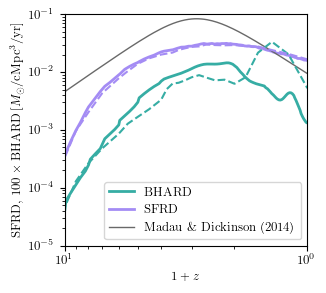

In [ ]:
plt.figure(figsize=(10/3, 3))
plt.plot(1+redshifts, 100*bh_accretion_rate_density_smoothed, label='BHARD', color=colour_map_2[4], linewidth=2)
plt.plot(1+redshifts, sfrd, label='SFRD', color=colour_map_2[6], linewidth=2)
plt.plot(1+redshifts, madau_sfr(redshifts), label='Madau \& Dickinson (2014)', color='dimgrey', linewidth=1)

compare = True # set as required

# plot comparison with FABLE 40 or other simulation if needed
if compare:
    # edit path as necessary
    bhard_40 = pd.read_csv('/cosma7/data/dp012/dc-butt3/BHs_FABLE_100/data/40_bh_accretion_rate_density.csv', sep=',', comment='#', header=0, dtype=float)
    bhard_z_40 = bhard_40['redshifts'].values
    bhard_40 = bhard_40['bh_accretion_rate_density'].values*u.Msun/u.Mpc**3
    bhard_40_smoothed = gaussian_filter1d(bhard_40.value, sigma=1)*u.Msun/u.yr/u.Mpc**3

    sfrd_40 = pd.read_csv('/cosma7/data/dp012/dc-butt3/BHs_FABLE_100/data/subhalo_sfr.csv', sep=',', comment='#', header=0, dtype=float)
    sfrd_z_40 = sfrd_40['Redshift'].values
    sfr_40 = sfrd_40['Total_SFR'].values*u.Msun/u.Mpc**3
    volume_40 = (40/LITTLE_H *u.Mpc)**3
    sfrd_40 = sfr_40/volume_40

    plt.plot(1+bhard_z_40, 100*bhard_40_smoothed, color=colour_map_2[4], linestyle = '--')
    plt.plot(1+sfrd_z_40, sfrd_40, color=colour_map_2[6], linestyle = '--')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$1 + z$')
plt.ylabel(r'SFRD, $100 \times \text{BHARD} \, [\text{M}_\odot/\text{cMpc}^{3}/\text{yr}]$')
plt.xlim(10, 1)
plt.ylim(1e-5, 1e-1)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.FixedLocator([10, 1]))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # Remove minor ticks
plt.legend()
plt.tight_layout()
plt.savefig('../figures/bh_accretion_rate_density.png', dpi = 600)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4008176/2344040752.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(1+redshifts, bhard1_smoothed, label='$M_{\mathrm{BH}} < 10^6 \mathrm{M}_\odot$', color=colour_map[1], linewidth =1)
/tmp/ipykernel_4008176/2344040752.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(1+redshifts, bhard2_smoothed, label='$10^6 \mathrm{M}_\odot < M_{\mathrm{BH}} < 10^7 \mathrm{M}_\odot$', color=colour_map[2], linewidth =1)
/tmp/ipykernel_4008176/2344040752.py:4: SyntaxWarning:

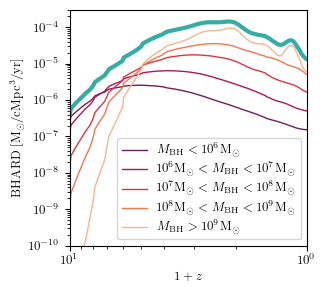

In [29]:
plt.figure(figsize=(10/3, 3))
plt.plot(1+redshifts, bhard1_smoothed, label='$M_{\mathrm{BH}} < 10^6 \mathrm{M}_\odot$', color=colour_map[1], linewidth =1)
plt.plot(1+redshifts, bhard2_smoothed, label='$10^6 \mathrm{M}_\odot < M_{\mathrm{BH}} < 10^7 \mathrm{M}_\odot$', color=colour_map[2], linewidth =1)
plt.plot(1+redshifts, bhard3_smoothed, label='$10^7 \mathrm{M}_\odot < M_{\mathrm{BH}} < 10^8 \mathrm{M}_\odot$', color=colour_map[3], linewidth =1)
plt.plot(1+redshifts, bhard4_smoothed, label='$10^8 \mathrm{M}_\odot<M_{\mathrm{BH}} < 10^9 \mathrm{M}_\odot$', color=colour_map[4], linewidth =1)
plt.plot(1+redshifts, bhard5_smoothed, label='$ M_{\mathrm{BH}} > 10^9 \mathrm{M}_\odot$', color=colour_map[5], linewidth =1)
plt.plot(1+redshifts, bh_accretion_rate_density_smoothed.to(u.Msun/u.yr/(u.Mpc)**3), color=colour_map_2[4], linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$1 + z$')
plt.ylabel(r'BHARD [M$_\odot$/cMpc$^{3}$/yr]')
plt.xlim(10,1)
plt.ylim(1e-10, 1e-4*3)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.FixedLocator([10, 1]))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # Remove minor ticks

plt.tight_layout()
plt.savefig('../figures/bh_accretion_rate_density_masses.png', dpi=600)

## Shen et al. (2020) Functions

These are necessary to compare to the observed mass density and qusar luminosity function.

In [14]:
H0 = LITTLE_H*100
Om0 = 0.3065
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# Equation (14) from Shen et al. (2020)
def gamma_1(z):
    a0 = 0.8569
    a1 = -0.2614
    a2 = 0.02
    gamma_1 = a0 + a1*(1+z)+a2*(2*(1+z)**2-1)
    return gamma_1

def gamma_2(z):
    b0 = 2.5375
    b1 = -1.0425
    b2 = 1.1201
    denominator = ((1+z)/(1+2))**b1+((1+z)/(1+2))**b2
    gamma_2 = 2*b0/denominator
    return gamma_2

def L_star(z):
    c0 = 13.0088
    c1 = -0.5759
    c2 = 0.4554
    denominator = ((1+z)/(1+2))**c1+((1+z)/(1+2))**c2
    log_l = 2*c0/denominator
    return 10**log_l

def phi_star(z_plus_1):
    d0 = -3.5426
    d1 = -0.3936
    log_phi = d0+d1*z_plus_1
    return 10**log_phi

# Equation (11)
def phi_bol(L, z):
    # luminosity is in solar luminosities
    L_st = L_star(z)
    return phi_star(1+z)/((L/L_st)**gamma_1(z)+(L/L_st)**gamma_2(z))

# Equation (28)
def inner_integrand(logL_bol,z):
    L_bol = 10**logL_bol
    # find L_bol as units of L_solar
    L = L_bol/3.846e33
    phi = phi_bol(L, z)
    return L_bol*phi

def integrand(z, epsilon_r):
    integral, _ = quad(inner_integrand, 43, 48, args=(z,))
    integral = integral * (u.erg/u.s/u.Mpc**3)
    return ((1-epsilon_r)/(epsilon_r*const.c**2*cosmo.H(z)*(1+z))*integral).to(u.Msun/(u.Mpc**3)).value

def mass_density(z, epsilon_r):
    integral, _ = quad(integrand, 10, z, args=(epsilon_r,))*u.Msun/(u.Mpc**3)
    return -integral


## BH Mass Density

In [19]:
# method for inset plot
def bh_statistics(snap_no):
    file_path_snap = base_path + f'/snapdir_{snap_no:03d}/snap_{snap_no:03d}.0.hdf5'
    with h5py.File(file_path_snap, 'r') as hf:
        header = dict(hf['Header'].attrs.items())
        h = header['HubbleParam']
    bh_masses = snapshot.loadSubset(base_path, snap_no, 5, fields='BH_Mass')*10**10/h

    bins = [0, 10**6, 10**7, 10**8, 10**9, 10**11]

    # Generate histogram
    histogram, bin_edges = np.histogram(bh_masses, bins=bins)

    # Calculate bar widths
    bar_widths = np.diff(bin_edges)
    # Append the last bar width
    bar_widths = np.append(bar_widths, bar_widths[-1])

    return bin_edges, histogram

In [15]:
bhmd1 = np.array([])*u.Msun/u.Mpc**3
bhmd2 = np.array([])*u.Msun/u.Mpc**3
bhmd3 = np.array([])*u.Msun/u.Mpc**3
bhmd4 = np.array([])*u.Msun/u.Mpc**3
bhmd5 = np.array([])*u.Msun/u.Mpc**3
total_bh_mass_density = np.array([])*u.Msun/u.Mpc**3

redshifts = np.array([])
for snap in range(1,136):
    file_path_snap = base_path+f"/snapdir_{snap:03d}/snap_{snap:03d}.0.hdf5"
    with h5py.File(file_path_snap, 'r') as hf:
        header = dict(hf['Header'].attrs.items())
        h = header['HubbleParam']
        redshift = header['Redshift']
        redshifts = np.append(redshifts, redshift)
        side_length = header['BoxSize']*u.kpc/h
        volume = (side_length**3).to(u.Mpc**3)
    bh_masses = snapshot.loadSubset(base_path, snap, 5, fields='BH_Mass')
    if isinstance(bh_masses, np.ndarray):
        bh_masses = bh_masses*10**10*u.Msun/h
        total_bh_mass = np.sum(bh_masses)
    else:
        bh_masses = np.array([])*u.Msun
        total_bh_mass = 0*10**10*u.Msun/h
    total_bh_mass_density = np.append(total_bh_mass_density, total_bh_mass/volume)

    masses1 = 0*u.Msun
    masses2 = 0*u.Msun
    masses3 = 0*u.Msun
    masses4 = 0*u.Msun
    masses5 = 0*u.Msun

    mass_bins = [0, 1e6, 1e7, 1e8, 1e9, np.inf] * u.Msun
    bin_indices = np.digitize(bh_masses.value, bins=[b.value for b in mass_bins])
    mass_density_bins = np.zeros(5)*u.Msun/(u.Mpc**3)
    for i in range(1, 6):
        masses_in_bin = bh_masses[bin_indices == i]
        mass_density_bins[i-1] = np.sum(masses_in_bin)/volume

    bhmd1 = np.append(bhmd1, mass_density_bins[0])
    bhmd2 = np.append(bhmd2, mass_density_bins[1])
    bhmd3 = np.append(bhmd3, mass_density_bins[2])
    bhmd4 = np.append(bhmd4, mass_density_bins[3])
    bhmd5 = np.append(bhmd5, mass_density_bins[4])

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2026209/3482562775.py:15: SyntaxWarning: invalid escape sequence '\o'
  line1,  = ax.plot(1+redshifts, bhmd1, label='$M_{BH} < 10^6 M_\odot$', color=colour_map[1], linewidth=1)
/tmp/ipykernel_2026209/3482562775.py:16: SyntaxWarning: invalid escape sequence '\o'
  line2,  = ax.plot(1+redshifts, bhmd2, label='$10^6 M_\odot < M_{BH} < 10^7 M_\odot$', color=colour_map[2], li

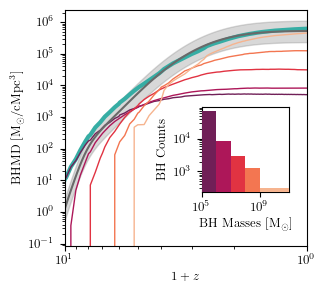

In [ ]:
# Getting values to plot Shen et al. (2020) mass density
one_plus_z = np.logspace(0, 1, 100)
mass_densities = np.array([])
lower_mass_density = np.array([])
upper_mass_density = np.array([])
for redshift in one_plus_z:
    mass_densities = np.append(mass_densities, (mass_density(redshift-1, 0.1).value))
    # Varying the radiative efficiency to get shaded region
    lower_mass_density = np.append(lower_mass_density, (mass_density(redshift-1, 0.05).value))
    upper_mass_density = np.append(upper_mass_density, (mass_density(redshift-1, 0.2).value))

plt.figure(figsize=(10/3, 3))
ax = plt.gca()
plt.plot(1+redshifts, total_bh_mass_density, color=colour_map_2[4], linewidth=3, label = 'FABLE total BHMD')
line1,  = ax.plot(1+redshifts, bhmd1, color=colour_map[1], linewidth=1)  
line2,  = ax.plot(1+redshifts, bhmd2, color=colour_map[2], linewidth=1)
line3,  = ax.plot(1+redshifts, bhmd3, color=colour_map[3], linewidth=1)
line4,  = ax.plot(1+redshifts, bhmd4, color=colour_map[4], linewidth=1)
line5,  = ax.plot(1+redshifts, bhmd5, color=colour_map[5], linewidth=1)
plt.plot(one_plus_z, mass_densities, color='dimgrey', label='Shen et al. (2020)', linewidth=1)
plt.fill_between(one_plus_z, lower_mass_density, upper_mass_density, color='gray', alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$1 + z$')
plt.ylabel(r'BHMD [M$_\odot$/cMpc$^{3}$]')
plt.xlim(10,1)
plt.legend(loc = 'upper left')
ax.xaxis.set_major_locator(ticker.FixedLocator([10, 1]))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # Remove minor ticks

# Add inset plot
ax2 = plt.gca()
inset_ax = inset_axes(ax2, width="40%", height="40%", loc='lower right', bbox_transform=ax2.transAxes, bbox_to_anchor=(0.05, 0.2, 0.9, 0.9))
# Adjust the bbox_to_anchor to add bottom padding
bbox = inset_ax.get_position()
inset_ax.set_position([bbox.x0, bbox.y0 - 1e4, bbox.width, bbox.height])
bin_edges, histogram = bh_statistics(135)
for i in range(len(histogram)):
    inset_ax.bar(bin_edges[i], histogram[i], width=np.diff(bin_edges)[i], color=colour_map[i+1], align="edge", zorder = 5)
inset_ax.set_xscale('log')
inset_ax.set_yscale('log')
inset_ax.set_xlim(10**5, 10**11)
inset_ax.set_xlabel('BH Masses [M$_\odot$]')
inset_ax.set_ylabel('BH Counts')

plt.tight_layout()
plt.savefig('../figures/bh_mass_density_masses.png', dpi=600)

## BH Mass Function

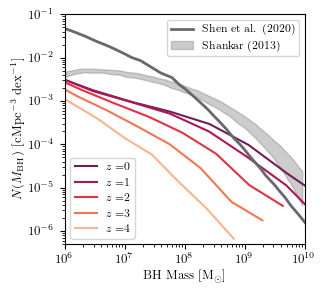

In [12]:
# Load Shankar (2013) data
blue_bottom = pd.read_csv('../data/blue_bottom.csv', sep=',', comment='#', header=None)
blue_top = pd.read_csv('../data/blue_top.csv', sep=',', comment='#', header=None)
red_bottom = pd.read_csv('../data/red_bottom.csv', sep=',', comment='#', header=None)
red_top = pd.read_csv('../data/red_top.csv', sep=',', comment='#', header=None)

blue_bottom_M = 10**blue_bottom[0].values
blue_bottom_phi = blue_bottom[1].values
blue_top_M = 10**blue_top[0].values
blue_top_phi = blue_top[1].values
red_bottom_M = 10**red_bottom[0].values
red_bottom_phi = red_bottom[1].values
red_top_M = 10**red_top[0].values
red_top_phi = red_top[1].values

sort_indices1 = np.argsort(blue_bottom_M)
sort_indices2 = np.argsort(blue_top_M)
sort_indices3 = np.argsort(red_bottom_M)
sort_indices4 = np.argsort(red_top_M)

blue_bottom_M = blue_bottom_M[sort_indices1]
blue_bottom_phi = blue_bottom_phi[sort_indices1]
blue_top_M = blue_top_M[sort_indices2]
blue_top_phi = blue_top_phi[sort_indices2]
red_bottom_M = red_bottom_M[sort_indices3]
red_bottom_phi = red_bottom_phi[sort_indices3]
red_top_M = red_top_M[sort_indices4]
red_top_phi = red_top_phi[sort_indices4]

blue_top_M_interp = np.interp(blue_bottom_M, blue_top_M, blue_top_phi)
red_top_M_interp = np.interp(red_bottom_M, red_top_M, red_top_phi)

# Load Shen et al. (2020) data

red_bhmf_shen = pd.read_csv('../data/red_bhmf.csv', sep=',', comment='#', header=None)
blue_bhmf_shen = pd.read_csv('../data/blue_bhmf.csv', sep=',', comment='#', header=None)

red_bhmf_shen_M = 10**(red_bhmf_shen[0].values)
red_bhmf_shen_phi = 10**(red_bhmf_shen[1].values)
blue_bhmf_shen_M = 10**(blue_bhmf_shen[0].values)
blue_bhmf_shen_phi = 10**(blue_bhmf_shen[1].values)

def generate_histogram(bh_masses, volume):
    bh_masses = bh_masses[bh_masses > 0]

    min_mass = np.min(bh_masses)
    max_mass = np.max(bh_masses)
    bins = np.logspace(np.log10(min_mass), np.log10(max_mass), 10)

    # Generate histogram
    histogram, bin_edges = np.histogram(bh_masses, bins=bins)
    bin_widths_dex = np.log10(bin_edges[1:]) - np.log10(bin_edges[:-1])

    histogram = histogram/volume/bin_widths_dex
    
    return histogram, bin_edges

file_path = os.path.join(base_path, 'snapdir_135', 'snap_135.0.hdf5')
with h5py.File(file_path, 'r') as hf:
    header = dict(hf['Header'].attrs.items())
    h = header['HubbleParam']
    box_size = header['BoxSize']*u.kpc/h
    volume = (box_size**3).to(u.Mpc**3)
    redshift = header['Redshift']

redshifts_wanted = np.array([0, 1, 2, 3, 4])
# get the snap numbers for the redshifts
scale_factors = util.get_scale_factors()
redshifts = 1/scale_factors - 1
closest_indices = [np.argmin(np.abs(redshifts - z)) for z in redshifts_wanted]
# Get the corresponding snapshot numbers
snap_nos_100 = [closest_indices[i] for i in range(len(closest_indices))]

# or manually set the snap numbers
# snap_nos_100 = [135, 85, 68, 60, 54]
histograms100 = {}
bin_edges100 = {}

for i, snap_no in enumerate(snap_nos_100):
    file_path = os.path.join(base_path, 'snapdir_' + str(snap_no).zfill(3), 'snap_' + str(snap_no).zfill(3) + '.0.hdf5')
    with h5py.File(file_path, 'r') as hf:
        header = dict(hf['Header'].attrs.items())
        h = header['HubbleParam']
        box_size = header['BoxSize']*u.kpc/h
        volume = (box_size**3).to(u.Mpc**3)
        redshift = header['Redshift']
        bh_masses = snapshot.loadSubset(base_path, snap_no, 5, fields='BH_Mass')*10**10/h

        histogram, bin_edges = generate_histogram(bh_masses, volume) 
        histograms100[redshifts_wanted[i]] = histogram
        bin_edges100[redshifts_wanted[i]] = bin_edges

        integral = np.sum(histogram * np.diff(bin_edges))*1/np.log(10)
        
data = pd.read_csv('../data/bhmf_shen.csv', header = None)
log_mbh = np.array(data[0])
log_phi = np.array(data[1])
shen_mbh = 10**log_mbh
shen_phi = 10**log_phi

fig, ax = plt.subplots(figsize=(10/3, 3))
# color_map = sns.color_palette("husl", 5)
for i,z in enumerate(redshifts_wanted):
    ax.plot(bin_edges100[z][:-1], histograms100[z], color = colour_map[i+1], label=r'$z = $'+str(z))
legend1 = ax.legend(fontsize=8, loc='lower left')
ax.add_artist(legend1)
line, = ax.plot(red_bhmf_shen_M, red_bhmf_shen_phi, color='dimgrey', linewidth=2, label='Shen et al. (2020)')

integral_shen = 1/np.log(10)*np.trapezoid(red_bhmf_shen_phi, red_bhmf_shen_M)
fill = ax.fill_between(red_bottom_M, red_bottom_phi, red_top_M_interp, color='gray', alpha=0.4, label = 'Shankar (2013)')
legend2 =ax.legend(handles=[line, fill],loc='upper right', fontsize = 8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'BH Mass [M$_{\odot}$]')
plt.ylabel(r'$N(M_{\mathrm{BH}})$ [cMpc$^{-3}$ dex$^{-1}$]')
plt.xlim(1e6, 1e10)
plt.ylim(5*1e-7, 1e-1)
plt.tight_layout()
plt.savefig('../figures/mass_function.png', dpi=600)

## Quasar Luminosity Function

Note: to get data points used for Shen fit go to: https://bitbucket.org/ShenXuejian/quasarlf/src/master/

In [13]:
EPSILON_R = 0.1

def eddington_rate(M_BH):
    epsilon_r = 0.1
    eddington_rate = 4*np.pi*const.G*M_BH*const.m_p/(0.1*const.sigma_T*const.c)
    return eddington_rate.to(u.Msun/u.Gyr)

def get_luminosity_koudmani(redshift):
    # bracketing by accounting for radiatively inefficient AGN following Koudmani et al. (2024)
    scale_factors = util.get_scale_factors()
    redshifts = 1/scale_factors - 1
    snap = np.argmin(np.abs(redshifts - redshift))
    luminosities_lower = []
    luminosities_upper = []

    # Load black hole data
    bh_data = snapshot.loadSubset(base_path, snap, 5, ['BH_Mdot', 'BH_Mass'])
    bh_masses = bh_data['BH_Mass'] * 1e10 * u.Msun / LITTLE_H
    bh_m_dot = snapshot.loadSubset(base_path, snap, 5, ['BH_Mdot']) * 1e10 * u.Msun / LITTLE_H / (0.978 * u.Gyr / LITTLE_H)

    for i, bh_mass in enumerate(bh_masses):
        edd_rate = eddington_rate(bh_mass)
        f_bh = bh_m_dot[i] / edd_rate

        # Calculate upper luminosity (quasar mode)
        luminosity_upper = (EPSILON_R * bh_m_dot[i] * const.c**2).to(u.erg / u.s).value

        if f_bh<0.1:
            if f_bh <= 1e-4:
                log_epsilon_r = -1.749 -0.267*np.log10(f_bh)-0.07492*np.log10(f_bh)**2
            elif f_bh < 0.023:
                log_epsilon_r = -0.807+0.27*np.log10(f_bh)
            else:
                log_epsilon_r = -1 - (0.0162/f_bh)**4
            epsilon_r = 10**log_epsilon_r
            luminosity_lower = (epsilon_r * bh_m_dot[i] * const.c**2).to(u.erg / u.s).value
        else:
            luminosity_lower = luminosity_upper

        # Append results if valid
        if luminosity_lower > 0 and luminosity_upper > 0:
            luminosities_lower.append(luminosity_lower)
            luminosities_upper.append(luminosity_upper)

    return luminosities_lower, luminosities_upper

/cosma/apps/dp012/dc-butt3/astroenv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


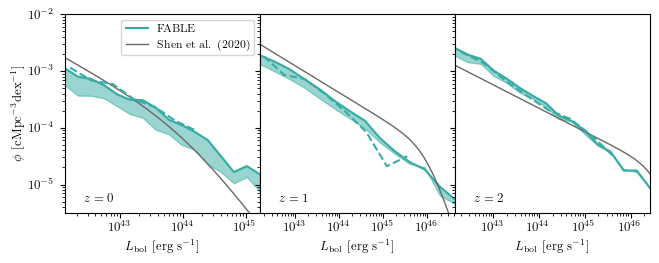

In [17]:
VOLUME = (100/LITTLE_H)**3

lum_upper = []
lum_lower = []

redshifts_wanted = [0, 1, 2]

for z in redshifts_wanted:
    lum_lower_z, lum_upper_z = get_luminosity_koudmani(z)
    lum_lower.append(lum_lower_z)
    lum_upper.append(lum_upper_z)

redshifts_wanted = [0, 1, 2]  # First three redshifts
scale_factors = util.get_scale_factors()
redshifts = 1 / scale_factors - 1

# Create a figure with 1x3 subplots using GridSpec
fig = plt.figure(figsize=(20/3, 2.7))
gs = GridSpec(1, 3, wspace=0)  # wspace=0 removes whitespace between plots

# Keep track of the global maximum of bin_centers_koudmani
global_y_min = np.inf
global_y_max = -np.inf

axs = []
for i, redshift in enumerate(redshifts_wanted):
    ax = fig.add_subplot(gs[0, i])
    axs.append(ax)

    # Load data and process
    lum_upper_koudmani = lum_upper[redshift]
    lum_lower_koudmani = lum_lower[redshift]

    bins_upper_koudmani = np.logspace(42, np.log10(np.max(lum_upper_koudmani)), 20)
    hist_koudmani, bins_koudmani = np.histogram(lum_upper_koudmani, bins=bins_upper_koudmani)
    bin_with_less_koudmani = np.where(hist_koudmani < 5)[0][0]  # Only bins with at least 5 BH particles
    hist_koudmani = hist_koudmani[:bin_with_less_koudmani]
    bins_koudmani = bins_koudmani[:bin_with_less_koudmani + 1]

    bins_lower_koudmani = np.logspace(42, np.log10(np.max(lum_lower_koudmani)), 20)
    hist_lower_koudmani, bins_lower_koudmani = np.histogram(lum_lower_koudmani, bins=bins_lower_koudmani)
    bin_with_less_lower_koudmani = np.where(hist_lower_koudmani < 5)[0][0]
    hist_lower_koudmani = hist_lower_koudmani[:bin_with_less_lower_koudmani]
    bins_lower_koudmani = bins_lower_koudmani[:bin_with_less_lower_koudmani + 1]

    bin_centers_koudmani = (bins_koudmani[:-1] + bins_koudmani[1:]) / 2
    bin_widths_dex_koudmani = np.log10(bins_koudmani[1:]) - np.log10(bins_koudmani[:-1])
    bin_centers_lower_koudmani = (bins_lower_koudmani[:-1] + bins_lower_koudmani[1:]) / 2
    bin_widths_dex_lower_koudmani = np.log10(bins_lower_koudmani[1:]) - np.log10(bins_lower_koudmani[:-1])
    interpolated_lower_values = np.interp(bin_centers_koudmani, bin_centers_lower_koudmani, hist_lower_koudmani / bin_widths_dex_lower_koudmani / VOLUME)

    # Track the global max x for cutting x-axis later
    max_x = np.max(bin_centers_koudmani)
    min_x = np.min(bin_centers_koudmani)

    y_min = np.min(hist_koudmani / bin_widths_dex_koudmani / VOLUME)
    y_max = np.max(hist_koudmani / bin_widths_dex_koudmani / VOLUME)

    # Update global y_min and y_max
    global_y_min = min(global_y_min, y_min)
    global_y_max = max(global_y_max, y_max)

    # Shen et al. model
    luminosities = np.logspace(42, 47, 1000)
    l_solar = luminosities / 3.846e33
    shen_phi = phi_bol(l_solar, redshift)

    # compare to smaller FABLE if necessary
    fable_40 = pd.read_csv(f'../data/luminosity_function_{int(redshift)}.csv')
    fable_40_L = np.array(fable_40['Luminosity'])
    fable_40_phi = np.array(fable_40['Phi'])

    # Plot the data
    ax.plot(bin_centers_koudmani, hist_koudmani / bin_widths_dex_koudmani / VOLUME, label=r'FABLE', color=colour_map_2[4])
    ax.fill_between(bin_centers_koudmani, interpolated_lower_values, hist_koudmani / bin_widths_dex_koudmani / VOLUME, alpha=0.5, color=colour_map_2[4])
    ax.plot(luminosities, shen_phi, color='dimgrey', linestyle='-', label='Shen et al. (2020)', linewidth=1)
    ax.plot(fable_40_L, fable_40_phi, color=colour_map_2[4], linestyle='--')

    # plot ovservational data
    if redshift == 0:
        z = 0.1
    else:
        z = redshift
    
    # Set axis scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Label axes
    ax.set_xlabel(r'$L_\mathrm{bol}$ [erg s$^{-1}$]')
    if i == 0:  # Only the first plot gets the y-axis label
        ax.set_ylabel(r'$\phi$ [cMpc$^{-3} \mathrm{dex}^{-1}]$')
        ax.tick_params(axis='y', which='both', labelleft=True)


    # Add a text annotation for redshift
    ax.text(0.1, 0.1, f'$z={redshift}$', transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='left')    
    ax.set_ylim(10**(-5.5), 1e-2)    
    ax.set_xlim(min_x, max_x)

for i,ax in enumerate(axs):
    ax.set_ylim(10**(-5.5), 1e-2)
    if i > 0:
        ax.set_yticklabels([])

axs[0].legend(loc='upper right', fontsize=8)

# Save and show
plt.tight_layout()
plt.savefig('../figures/qlf.png', dpi=600)
plt.show()